In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import pystan
%config InlineBackend.figure_format = 'retina'

In [3]:
full_df = pd.read_csv('data.csv')
full_df['start_date'] = pd.to_datetime(full_df['start_date'])

In [5]:
# Calculate serve points won
loser_spw_won = full_df['winner_return_points_total'] - full_df['winner_return_points_won']
loser_sp_total = full_df['winner_return_points_total']
losers = full_df['loser']

winner_spw_won = full_df['loser_return_points_total'] - full_df['loser_return_points_won']
winner_spw_total = full_df['loser_return_points_total']
winners = full_df['winner']

months_since_start = ((full_df['start_date'] - full_df['start_date'].min()) / np.timedelta64(1, 'M')).astype(int)
period = months_since_start // 3 + 1

In [6]:
winner_frame = pd.DataFrame({'server': winners, 'returner': losers, 'sp_won': winner_spw_won, 
                             'sp_total': winner_spw_total, 'period': period})
loser_frame = pd.DataFrame({'server': losers, 'returner': winners, 'sp_won': loser_spw_won, 
                            'sp_total': loser_sp_total, 'period': period})

combined = pd.concat([winner_frame, loser_frame])

# Drop the index
combined = combined.reset_index(drop=True)

In [7]:
combined['period'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [8]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

all_players = combined['server'].tolist() + combined['returner'].tolist()

encoder.fit(all_players)

server_ids = encoder.transform(combined['server'].values)
returner_ids = encoder.transform(combined['returner'].values)

In [9]:
model = """
data {
    int<lower=0> num_matches;
    int<lower=0> num_players;
    int<lower=0> num_periods;
    
    int s_id[num_matches]; // server ids
    int r_id[num_matches]; // returner ids
    int period[num_matches]; // the current period
    
    int spw[num_matches]; // serve points won
    int spt[num_matches]; // serve points total
}
parameters {
    matrix[num_periods, num_players] s; // serving ability
    matrix[num_periods, num_players] r; // returning ability
    
    real<lower=0> sigma_s; // variance for hyperprior on initial s
    real<lower=0> sigma_r; // variance for hyperprior on initial r
    
    real<lower=0> sigma_t_s; // the time dependence on serve
    real<lower=0> sigma_t_r; // the time dependence on return   
    
    real theta_0; // intercept for serve probability
}
model {
    vector[num_matches] cur_logit;

    // priors
    sigma_s ~ normal(0, 1);
    sigma_r ~ normal(0, 1);
    sigma_t_s ~ normal(0, 1);
    sigma_t_r ~ normal(0, 1);
    theta_0 ~ normal(0, 1);
    
    // Initial prior
    s[1, :] ~ normal(0, sigma_s);
    r[1, :] ~ normal(0, sigma_r);
    
    // Time development
    for (i in 2:num_periods){
        s[i, :] ~ normal(s[i-1, :], sigma_t_s);
        r[i, :] ~ normal(r[i-1, :], sigma_t_r);
    }
    
    for (i in 1:num_matches){
        cur_logit[i] = s[period[i], s_id[i]] - r[period[i], r_id[i]] + theta_0;
    }
    
    // Likelihood
    spw ~ binomial_logit(spt, cur_logit);
}
"""

stan_model = pystan.StanModel(model_code=model)

In [10]:
stan_data = {'num_matches': combined.shape[0],
             'num_players': len(encoder.classes_),
             's_id': server_ids + 1,
             'r_id': returner_ids + 1,
             'spw': combined['sp_won'].values.astype(int),
             'spt': combined['sp_total'].values.astype(int),
             'period': combined['period'].values.astype(int),
             'num_periods': len(combined['period'].unique())}

fit = stan_model.sampling(data=stan_data)

In [11]:
results = fit.extract()

In [12]:
all_players = encoder.inverse_transform(range(len(encoder.classes_)))

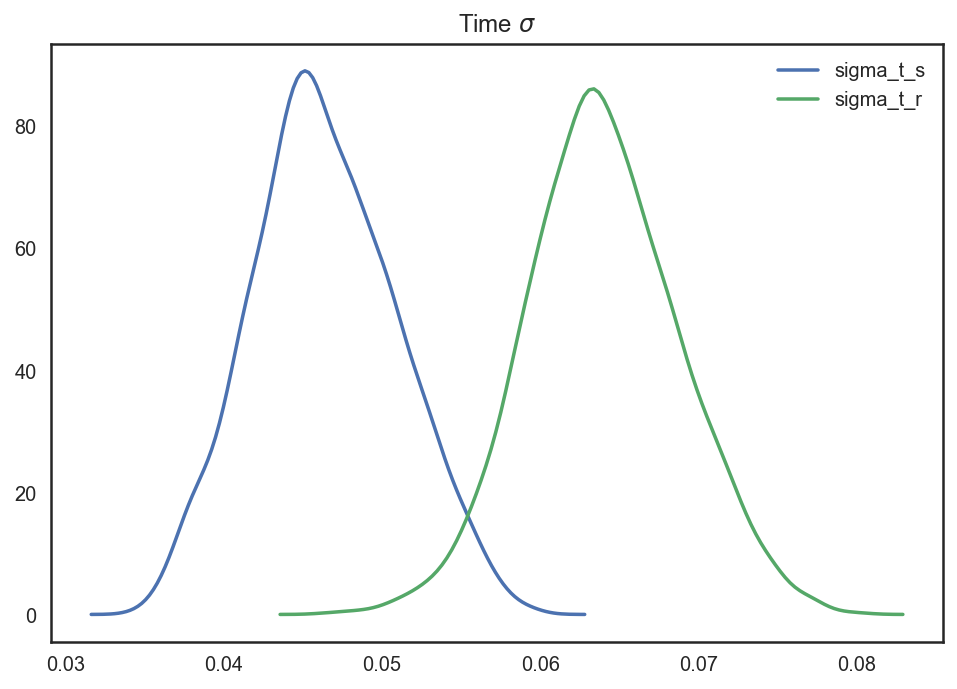

In [33]:
# What is the time sigma?
sns.kdeplot(results['sigma_t_s'], label='sigma_t_s')
sns.kdeplot(results['sigma_t_r'], label='sigma_t_r')

plt.legend()
plt.title('Time $\sigma$')

In [14]:
results['s'].shape

(4000, 7, 352)

In [15]:
s_means = pd.Series(results['s'][:, -1, :].mean(axis=0), index=all_players)
s_means.sort_values(ascending=False).head()

John Isner        0.599703
Roger Federer     0.579983
Ivo Karlovic      0.540054
Milos Raonic      0.513102
Kevin Anderson    0.454075
dtype: float64

In [16]:
r_means = pd.Series(results['r'][:, -1, :].mean(axis=0), index=all_players)
r_means.sort_values(ascending=False).head()

Rafael Nadal                   0.494419
Diego Sebastian Schwartzman    0.392338
Novak Djokovic                 0.363333
Andy Murray                    0.353651
Roger Federer                  0.332321
dtype: float64

In [17]:
overall_strength = s_means + r_means
overall_strength.sort_values(ascending=False).head(10)

Rafael Nadal        0.935220
Roger Federer       0.912304
Marin Cilic         0.719678
Novak Djokovic      0.675361
Alexander Zverev    0.633148
Nick Kyrgios        0.583830
Milos Raonic        0.569900
Andy Murray         0.556640
Kevin Anderson      0.554881
Dominic Thiem       0.513411
dtype: float64

In [18]:
overall = results['r'] + results['s']
overall.shape

(4000, 7, 352)

In [19]:
full_df['start_date'].min()

Timestamp('2016-01-04 00:00:00')

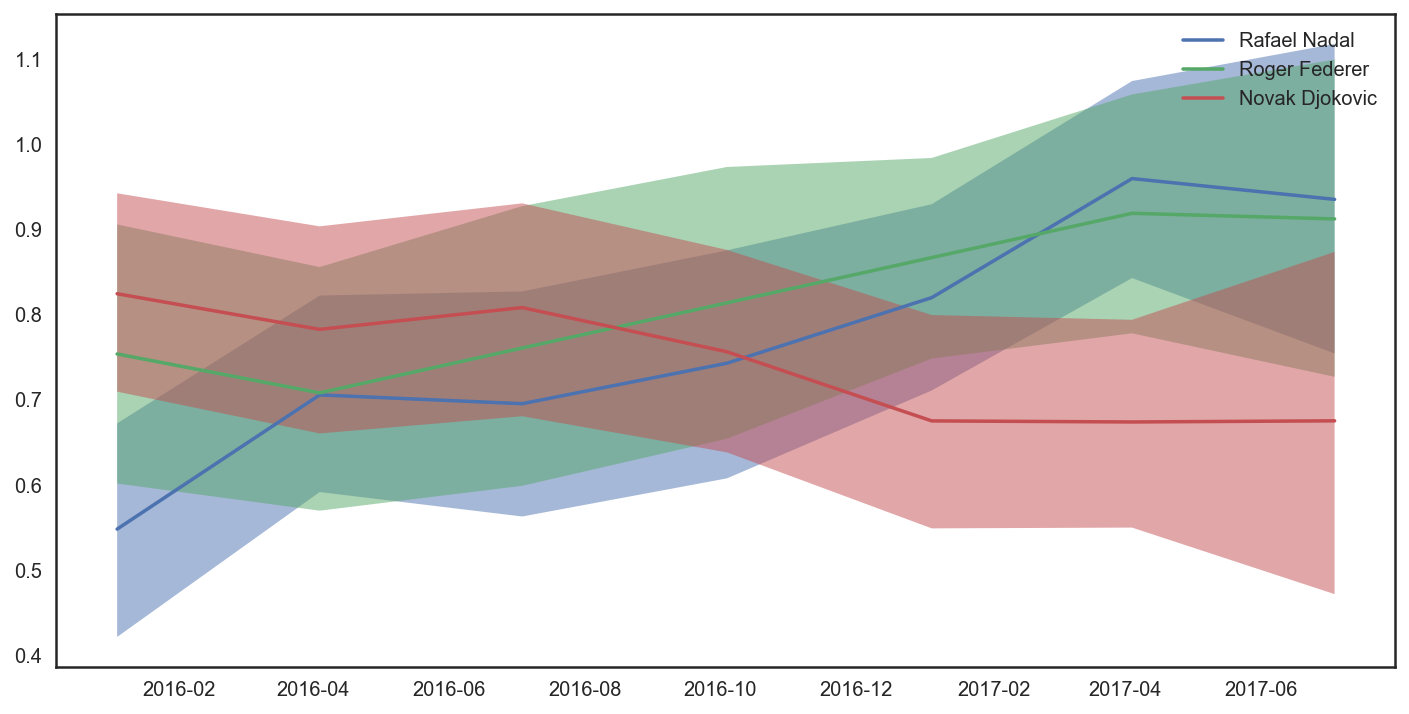

In [23]:
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

sns.set_style('white')

players = ['Rafael Nadal', 'Roger Federer', 'Novak Djokovic']

dates = [full_df['start_date'].min() + x * relativedelta(months=+3) for x in range(overall.shape[1])]

for cur_player in players:
    
    cur_id = encoder.transform([cur_player])[0]
    cur_overall = overall[:, :, cur_id]
    
    plt.plot(dates, cur_overall.mean(axis=0), label=cur_player)
    plt.fill_between(dates, np.percentile(cur_overall, 2.5, axis=0), 
                     np.percentile(cur_overall, 97.5, axis=0), alpha=0.5)
    
plt.legend()

plt.gcf().set_size_inches(12, 6)

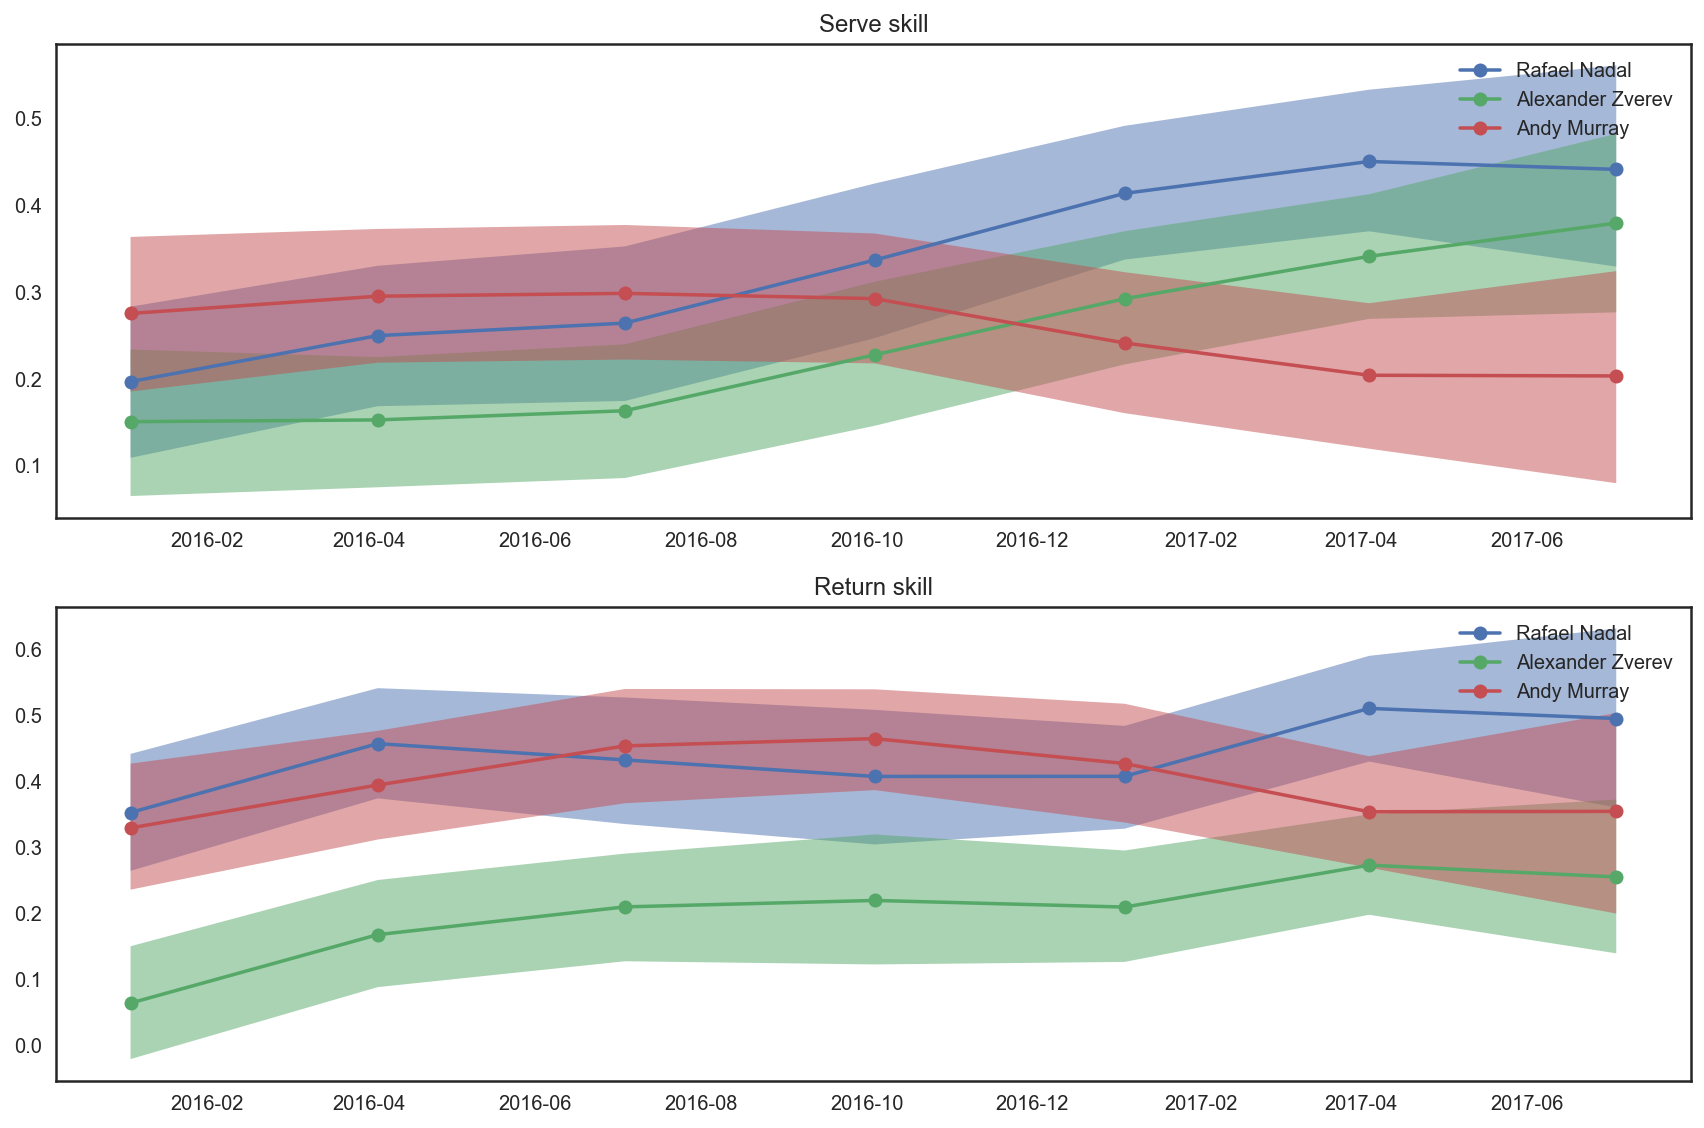

In [43]:
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

sns.set_style('white')

f, ax = plt.subplots(2, 1)

players = ['Rafael Nadal', 'Alexander Zverev', 'Andy Murray']

dates = [full_df['start_date'].min() + x * relativedelta(months=+3) for x in range(overall.shape[1])]

for cur_player in players:
    
    cur_id = encoder.transform([cur_player])[0]
    cur_s = results['s'][:, :, cur_id]
    cur_r = results['r'][:, :, cur_id]
    
    ax[0].plot(dates, cur_s.mean(axis=0), label=cur_player, marker='o')
    ax[0].fill_between(dates, np.percentile(cur_s, 2.5, axis=0), 
                     np.percentile(cur_s, 97.5, axis=0), alpha=0.5)
    
    ax[1].plot(dates, cur_r.mean(axis=0), label=cur_player, marker='o')
    ax[1].fill_between(dates, np.percentile(cur_r, 2.5, axis=0), 
                     np.percentile(cur_r, 97.5, axis=0), alpha=0.5)
    
ax[0].legend()
ax[1].legend()

ax[0].set_title('Serve skill')
ax[1].set_title('Return skill')

plt.gcf().set_size_inches(12, 8)
plt.gcf().tight_layout()